# Web Scraping 

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

######1. Web scraping the wiki page
#Make a request to the webpage
url = 'https://en.wikipedia.org/wiki/Legality_of_cryptocurrency_by_country_or_territory'
response = requests.get(url)
#Parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')
#Find all the tables in the webpage
tables = soup.find_all('table', {'class': 'wikitable'})
#Initialize an empty list to store the data
data = []
#Iterate through the tables
for table in tables:
    #Iterate through the rows of the table
    for row in table.find_all('tr'):
        cells = row.find_all('td')
        if len(cells) > 0:
            #Extract the information from each cell
            country = cells[0].text.strip()
            status = cells[1].text.strip()
            #Split the legal status by '\n'
            status_list = status.split('\n')
            #Get the legal status
            legal_status = status_list[0]
            #Get the text
            remaining_text = " ".join(status_list[1:])
            #Extract the date from the text
            date_match = re.search(r'(\d{1,2}\s[A-Za-z]+\s\d{4}|\d{4}|\d{1,2}\s[A-Za-z]+\s\d{2}|\b[A-Za-z]+\s\d{4}\b)', remaining_text)
            if date_match:
                date = date_match.group()
            else:
                date = ""
            data.append([country, legal_status, remaining_text, date])
#Create a pandas DataFrame from the list
df = pd.DataFrame(data, columns=['Country', 'Legal Status','Remaining Text', 'Date In Text'])
#Get the reference number in the remaining text
reference_number = []
for i in range(len(df)):
    num  = ' '.join(set(re.findall(r"\[(\d+)\]",df['Remaining Text'][i])))
    reference_number.append(num)
df['Reference number'] = reference_number
#Reset the index
df1 = df.set_index(['Country', 'Legal Status','Remaining Text', 'Date In Text']).apply(lambda x: x.str.split(' ').explode()).reset_index()

#Web scraping the citation number, citation link, and citation date from the citation section at the bottom of the wiki page
ref_section = soup.find_all("ol", class_="references")
references = ref_section[1].find_all('li')
#Save the reference id and reference link
id = []
links = []
dates = []
for i in range(0,len(references)):
  id.append(references[i].get('id')) #Get the citation id
  text = references[i].text
  ref_dates = []
  #Get the date in citation(time has different formats)
  date_match = re.findall(r'(?P<day>\d+)\s+(?P<month>\w+)\s+(?P<year>\d{4})', text)
  if date_match:
    for match in date_match:
        day = match[0]
        month = match[1]
        year = match[2]
        ref_dates.append(f"{day} {month} {year}")
  else:
    date_match = re.findall(r'(?P<month>\w+)\s+(?P<year>\d{4})', text)
    if date_match:
        for match in date_match:
            month = match[0]
            year = match[1]
            ref_dates.append(f"{month} {year}")
  if len(ref_dates) > 0:
    dates.append(ref_dates)
  else:
    dates.append("NA")
  #Get the citation link
  try:
    links.append(references[i].find_all("a", class_="external text")[0].get('href')) #Get the citation link when class is external text
  except:
    links.append(references[i].find_all("a", class_="external free")[0].get('href')) #Get the citation link when class is external free
#Create a DataFrame from the list
df2 = pd.DataFrame({'Citation Id':id, 'Citation Link':links, 'Citation Date':dates })
#Get the citation number
citation_number = []
for i in range(len(df2)):
  id = re.findall(r'\b\d+\b', df2['Citation Id'][i])[-1]
  citation_number.append(id)
df2['Citation number'] = citation_number

#Merged the web scraping dataframe with the reference dataframe
merged = pd.merge(df1, df2, left_on='Reference number', right_on='Citation number', how ="outer")
merged.sort_values(by='Country', ascending=True, inplace=True)
merged.reset_index(drop=True, inplace=True)

# Extract only the first element before the comma in the citation date(want to get the earliest date if there are two date information)
merged['Citation Date'] = merged['Citation Date'].apply(lambda x: x[0].split(',')[0] if isinstance(x, list) and len(x) > 0 else '')

#Ensure all the date is in the format: yyyy-mm-dd
merged['Date In Text'] = pd.to_datetime(merged['Date In Text'], errors='coerce').dt.strftime('%Y-%m-%d')
merged['Citation Date'] = pd.to_datetime(merged['Citation Date'], errors='coerce').dt.strftime('%Y-%m-%d')



######2. Web scraping the article contents

#Web scraping all the article contents
%pip install newspaper3k
#Using newspaper3k to extract the articles of the links
from newspaper import Article
#Article extraction function
def extract_article_contents(url):
    article = Article(url)
    article.download()
    article.parse()
    return article.text
#Append the article contents to the dataframe
article_contents = []
for link in merged['Citation Link']:
    try:
      article_contents.append(extract_article_contents(link))
    except:
      try:
        from newspaper import Config
        user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
        config = Config()
        config.browser_user_agent = user_agent 
        article = Article(link, config=config)
        article.download()
        article.parse()
        article_contents.append(article.text)
      except:
        article_contents.append("No Link")
#Put article contents into the dataframe
merged['Article Contents'] = article_contents
display(merged)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,Country,Legal Status,Remaining Text,Date In Text,Reference number,Citation Id,Citation Link,Citation Date,Citation number,Article Contents
0,Afghanistan,Illegal,In August 2022 Taliban banned trading in cryp...,2022-08-01,57,cite_note-57,https://www.bloomberg.com/news/articles/2022-0...,2022-08-26,57,Why did this happen?\n\nPlease make sure your ...
1,Albania,Legal,"On 21 May 2020, Albania passed a new law to r...",2020-05-21,150,cite_note-150,https://www.tagesanzeiger.ch/schweizer-boerse-...,2021-06-11,150,Digitale Währung im Aufwind – Schweizer Börse ...
2,Algeria,Illegal,"According to the ""Journal Officiel"" (28 Decem...",2017-12-28,14,cite_note-RCAWJune2018LOC-14,https://www.loc.gov/item/2021687419/,2018-08-14,14,Publications of the Law Library of Congress ar...
3,Algeria,Illegal,"According to the ""Journal Officiel"" (28 Decem...",2017-12-28,13,cite_note-13,https://www.joradp.dz/FTP/jo-francais/2017/F20...,2019-01-03,13,
4,Angola,Legal,While government officials have advised again...,NaN,24,cite_note-24,https://www.youtube.com/watch?v=CxporKEMZY4,2020-01-07,24,
...,...,...,...,...,...,...,...,...,...,...
241,Zimbabwe,Unknown,The Reserve Bank Of Zimbabwe has banned the b...,NaN,28,cite_note-RCAWNovember2021LOC-28,https://tile.loc.gov/storage-services/service/...,2022-02-09,28,
242,NaN,NaN,NaN,NaN,NaN,cite_note-1,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2017-09-25,1,18 Pages Posted: 24 Sep 2017 Last revised: 26 ...
243,NaN,NaN,NaN,NaN,NaN,cite_note-2,https://medium.com/coinmonks/cryptos-big-legal...,2018-09-25,2,(This is the first part of a larger analytical...
244,NaN,NaN,NaN,NaN,NaN,cite_note-153,https://expathub.ge/cryptocurrency-in-georgia/,2021-09-28,153,With relaxed laws and 0% tax on income from tr...


# Translate the article contents

In [3]:
#Not work so well with all the translation
!pip install googletrans==4.0.0-rc1

from googletrans import Translator

#Create a translator object
translator = Translator()

#Translate all the articles
article_contents_en = []
for article in merged['Article Contents']:
    try:
        article_en = translator.translate(article, dest='en').text
        article_contents_en.append(article_en)
    except:
        article_contents_en.append("Translation Unavailable")
#Add the translated articles to the DataFrame
merged['Article Contents (EN)'] = article_contents_en
display(merged)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.8 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=2a5f5df006b17e8d9a9af69b09e895902ae0e4fbb827bfdcbc1cca7994d280ba
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans

,Country,Legal Status,Remaining Text,Date In Text,Reference number,Citation Id,Citation Link,Citation Date,Citation number,Article Contents,Article Contents (EN)
0,Afghanistan,Illegal,In August 2022 Taliban banned trading in cryp...,2022-08-01,57,cite_note-57,https://www.bloomberg.com/news/articles/2022-0...,2022-08-26,57,Why did this happen?\n\nPlease make sure your ...,Why did this happen?\n\nPlease make sure your ...
1,Albania,Legal,"On 21 May 2020, Albania passed a new law to r...",2020-05-21,150,cite_note-150,https://www.tagesanzeiger.ch/schweizer-boerse-...,2021-06-11,150,Digitale Währung im Aufwind – Schweizer Börse ...,Digital currency on the upswing - Swiss stock ...
2,Algeria,Illegal,"According to the ""Journal Officiel"" (28 Decem...",2017-12-28,14,cite_note-RCAWJune2018LOC-14,https://www.loc.gov/item/2021687419/,2018-08-14,14,Publications of the Law Library of Congress ar...,Publications of the Law Library of Congress ar...
3,Algeria,Illegal,"According to the ""Journal Officiel"" (28 Decem...",2017-12-28,13,cite_note-13,https://www.joradp.dz/FTP/jo-francais/2017/F20...,2019-01-03,13,,Translation Unavailable
4,Angola,Legal,While government officials have advised again...,NaN,24,cite_note-24,https://www.youtube.com/watch?v=CxporKEMZY4,2020-01-07,24,,Translation Unavailable
...,...,...,...,...,...,...,...,...,...,...,...
241,Zimbabwe,Unknown,The Reserve Bank Of Zimbabwe has banned the b...,NaN,28,cite_note-RCAWNovember2021LOC-28,https://tile.loc.gov/storage-services/service/...,2022-02-09,28,,Translation Unavailable
242,NaN,NaN,NaN,NaN,NaN,cite_note-1,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2017-09-25,1,18 Pages Posted: 24 Sep 2017 Last revised: 26 ...,18 Pages Posted: 24 Sep 2017 Last revised: 26 ...
243,NaN,NaN,NaN,NaN,NaN,cite_note-2,https://medium.com/coinmonks/cryptos-big-legal...,2018-09-25,2,(This is the first part of a larger analytical...,(This is the first part of a larger analytical...
244,NaN,NaN,NaN,NaN,NaN,cite_note-153,https://expathub.ge/cryptocurrency-in-georgia/,2021-09-28,153,With relaxed laws and 0% tax on income from tr...,Translation Unavailable


# Display rows with empty article contents and translation is unavailable





In [4]:
#Rows that do not scrape the article contents correctly
#Create a boolean mask to identify rows with empty or NA "Article Contents"
mask = merged['Article Contents'].isna() | (merged['Article Contents'] == '')
#Filter the DataFrame using the boolean mask
missing_articles = merged[mask]
#Display the filtered DataFrame
display(missing_articles)


,Country,Legal Status,Remaining Text,Date In Text,Reference number,Citation Id,Citation Link,Citation Date,Citation number,Article Contents,Article Contents (EN)
3,Algeria,Illegal,"According to the ""Journal Officiel"" (28 Decem...",2017-12-28,13,cite_note-13,https://www.joradp.dz/FTP/jo-francais/2017/F20...,2019-01-03,13,,Translation Unavailable
4,Angola,Legal,While government officials have advised again...,NaN,24,cite_note-24,https://www.youtube.com/watch?v=CxporKEMZY4,2020-01-07,24,,Translation Unavailable
18,Brazil,Legal,"In December 2022, Brazil established a licens...",2022-12-01,52,cite_note-52,http://www.bcb.gov.br/pre/normativos/busca/nor...,2017-11-17,52,,Translation Unavailable
21,Brunei,Legal to trade and hold,Bitcoin and cryptocurrency is not legal tender...,NaN,126,cite_note-126,https://web.archive.org/web/20181215223312/htt...,2018-12-15,126,,Translation Unavailable
33,China (PRC),Illegal,Financial institutions are not allowed to fac...,2013-12-05,8,cite_note-EUPARANNEX-8,http://www.europarl.europa.eu/RegData/biblioth...,2015-02-18,8,,Translation Unavailable
42,Czech Republic,Legal,"Businesses and individuals who buy, sell, sto...",NaN,128,cite_note-128,https://www.mfcr.cz/cs/verejny-sektor/ucetnict...,2018-05-22,128,,Translation Unavailable
48,Ecuador,Legal to trade and hold / Illegal as a paymen...,Usage of any cryptocurrency as a payment tool...,2021-01-01,54,cite_note-54,https://tile.loc.gov/storage-services/service/...,2021-11-01,54,,Translation Unavailable
60,European Union,Legal,The European Union has passed no specific leg...,2015-10-01,7,cite_note-ECB-7,http://www.ecb.europa.eu/pub/pdf/other/virtual...,2014-03-05,7,,Translation Unavailable
64,European Union,Legal,The European Union has passed no specific leg...,2015-10-01,8,cite_note-EUPARANNEX-8,http://www.europarl.europa.eu/RegData/biblioth...,2015-02-18,8,,Translation Unavailable
66,European Union,Legal,The European Union has passed no specific leg...,2015-10-01,9,cite_note-EBA-9,http://www.eba.europa.eu/documents/10180/65754...,2014-07-04,9,,Translation Unavailable


In [5]:
#Rows that do not translate the article contents correctly
unavailable_rows = merged[merged['Article Contents (EN)'] == 'Translation Unavailable']
display(unavailable_rows)

,Country,Legal Status,Remaining Text,Date In Text,Reference number,Citation Id,Citation Link,Citation Date,Citation number,Article Contents,Article Contents (EN)
3,Algeria,Illegal,"According to the ""Journal Officiel"" (28 Decem...",2017-12-28,13,cite_note-13,https://www.joradp.dz/FTP/jo-francais/2017/F20...,2019-01-03,13,,Translation Unavailable
4,Angola,Legal,While government officials have advised again...,NaN,24,cite_note-24,https://www.youtube.com/watch?v=CxporKEMZY4,2020-01-07,24,,Translation Unavailable
18,Brazil,Legal,"In December 2022, Brazil established a licens...",2022-12-01,52,cite_note-52,http://www.bcb.gov.br/pre/normativos/busca/nor...,2017-11-17,52,,Translation Unavailable
21,Brunei,Legal to trade and hold,Bitcoin and cryptocurrency is not legal tender...,NaN,126,cite_note-126,https://web.archive.org/web/20181215223312/htt...,2018-12-15,126,,Translation Unavailable
27,Canada,Legal / Banking ban,Companies dealing in virtual currencies must ...,2018-04-01,29,cite_note-29,http://www.fintrac-canafe.gc.ca/msb-esm/intro-...,2017-09-05,29,"Accountant\n\nA chartered accountant, a certif...",Translation Unavailable
...,...,...,...,...,...,...,...,...,...,...,...
236,Uzbekistan,Legal,"On 2 September 2018, a decree legalizing cryp...",2018-09-02,61,cite_note-61,https://static.norma.uz/official_texts/%D0%9E%...,2018-02-01,61,,Translation Unavailable
237,Vanuatu,Legal,Legalised in 2021.[193],NaN,193,cite_note-193,https://www.rnz.co.nz/international/pacific-ne...,2021-03-14,193,The tiny Pacific Island nation of Tuvalu is pl...,Translation Unavailable
240,Vietnam,Legal to trade and hold / Illegal as payment ...,The State Bank of Vietnam has declared that t...,NaN,124,cite_note-124,https://tuoitre.vn/news-20171028102135916.htm,2017-10-28,124,,Translation Unavailable
241,Zimbabwe,Unknown,The Reserve Bank Of Zimbabwe has banned the b...,NaN,28,cite_note-RCAWNovember2021LOC-28,https://tile.loc.gov/storage-services/service/...,2022-02-09,28,,Translation Unavailable


# Word Cloud


1.   First three wordclouds for wiki page
2.   Last three wordclouds for article contents




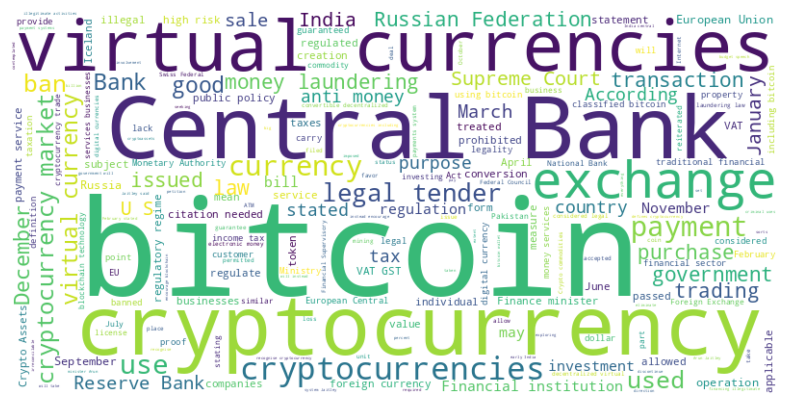

In [6]:
#Import necessary libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#Legal Status: Legal

#Filter the data to include only countries with legal status starting with "Legal"
merged = merged.dropna(subset=["Remaining Text"])
#Filter the DataFrame to include only the rows where the legal status starts with "Legal"
legal_countries = merged[merged["Legal Status"].str.startswith("Legal")]
#Join all the remaining text for the selected countries into a single string
text = ' '.join(legal_countries['Remaining Text'])
#Create a set of stopwords to exclude from the wordcloud
stopwords = set(STOPWORDS)
stopwords.update(["one", "two", "three"])  # add additional stopwords as needed
#Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)
#Display the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

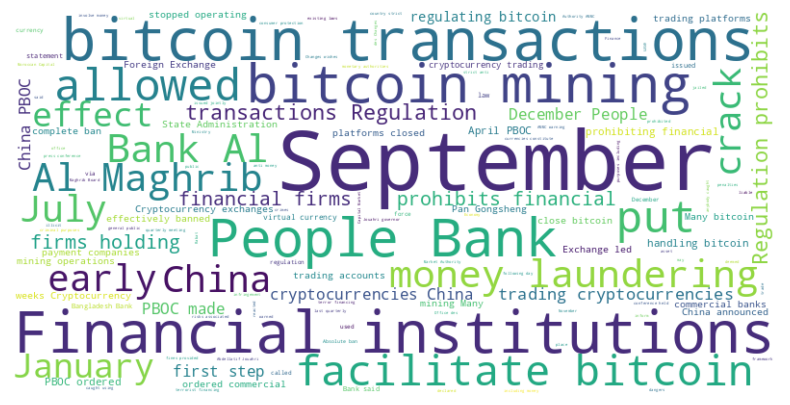

In [7]:
#Legal Status: Illegal

#Filter the data to include only countries with legal status starting with "Legal"
merged = merged.dropna(subset=["Remaining Text"])
#Filter the DataFrame to include only the rows where the legal status starts with "Legal"
illegal_countries = merged[merged["Legal Status"]=='Illegal']
#Join all the remaining text for the selected countries into a single string
text1 = ' '.join(illegal_countries['Remaining Text'])
#Create a set of stopwords to exclude from the wordcloud
stopwords = set(STOPWORDS)
stopwords.update(["one", "two", "three"])  # add additional stopwords as needed
#Create a WordCloud object
wordcloud1 = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text1)
#Display the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.show()

(62, 11)


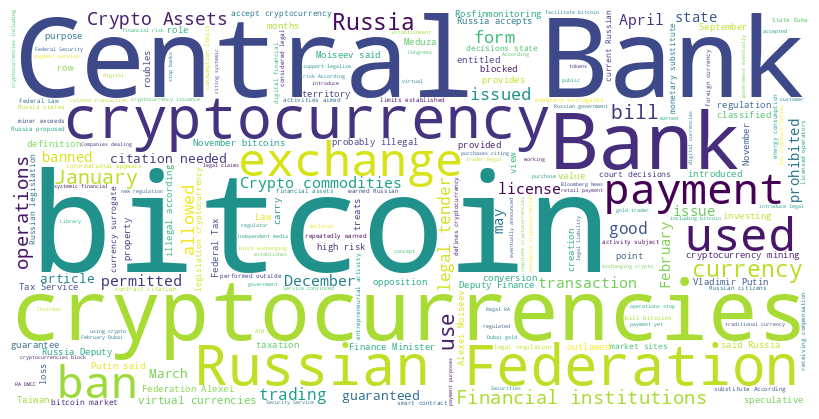

In [8]:
#Legal Status: Others

#Filter for the countries with legal status not starting with "Legal" and not "Illegal"
legal_status_mask = merged[(merged['Legal Status'] != 'Legal') & (merged['Legal Status'] != 'Illegal')]
print(legal_status_mask.shape)
#Join all remaining text into a single string
text2 = ' '.join(legal_status_mask['Remaining Text'])
#Create a set of stopwords to exclude from the wordcloud
stopwords = set(STOPWORDS)
stopwords.update(["one", "two", "three"])  # add additional stopwords as needed
#Create a WordCloud object
wordcloud2 = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text2)
#Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud2)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

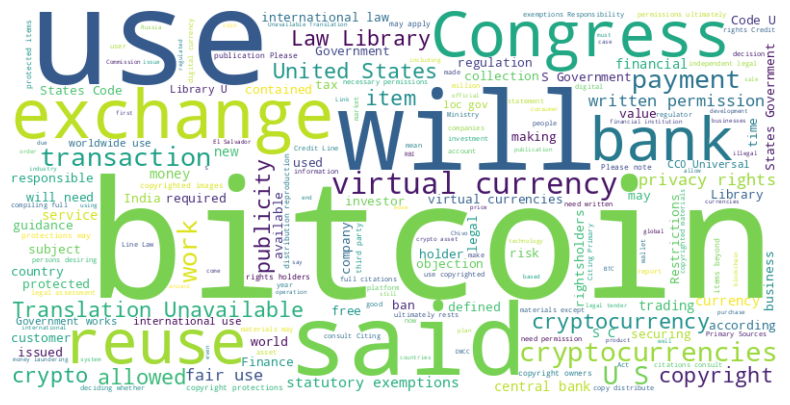

In [9]:
#Legal Status: Legal

#Filter the data to include only countries with legal status starting with "Legal"
merged = merged.dropna(subset=['Article Contents (EN)'])
#Filter the DataFrame to include only the rows where the legal status starts with "Legal"
legal_countries1 = merged[merged["Legal Status"].str.startswith("Legal")]
#Join all the remaining text for the selected countries into a single string
text3 = ' '.join(legal_countries1['Article Contents (EN)'])
#Create a set of stopwords to exclude from the wordcloud
stopwords = set(STOPWORDS)
stopwords.update(["one", "two", "three"])  # add additional stopwords as needed
#Create a WordCloud object
wordcloud3 = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text3)
#Display the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis('off')
plt.show()

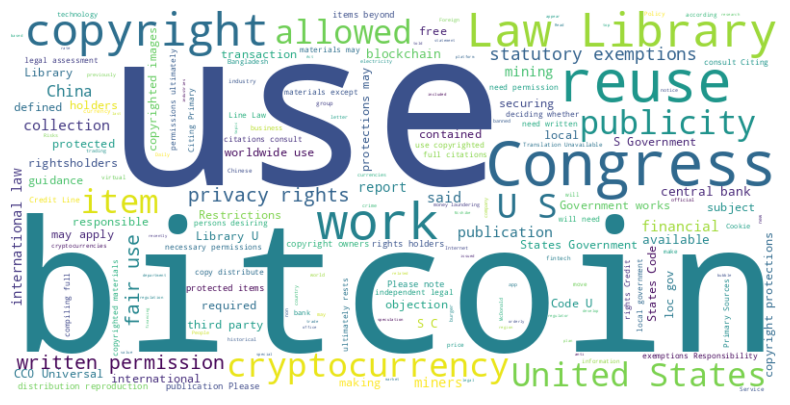

In [10]:
#Legal Status: Illegal

#Filter the data to include only countries with legal status starting with "Legal"
merged = merged.dropna(subset=['Article Contents (EN)'])
#Filter the DataFrame to include only the rows where the legal status starts with "Legal"
illegal_countries1 = merged[merged["Legal Status"]=='Illegal']
#Join all the remaining text for the selected countries into a single string
text4 = ' '.join(illegal_countries1['Article Contents (EN)'])
#Create a set of stopwords to exclude from the wordcloud
stopwords = set(STOPWORDS)
stopwords.update(["one", "two", "three"])  # add additional stopwords as needed
#Create a WordCloud object
wordcloud4 = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text4)
#Display the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud4, interpolation='bilinear')
plt.axis('off')
plt.show()

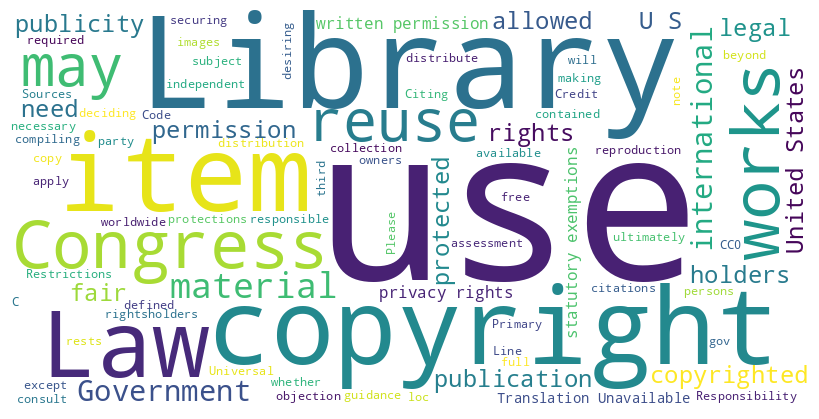

In [11]:
#Legal Status: Others

#Filter for the countries with legal status not starting with "Legal" and not "Illegal"
legal_status_mask1 = ~merged['Legal Status'].str.startswith('Legal', na=False) & (merged['Legal Status'] != 'Illegal')
remaining_text1 = merged.loc[legal_status_mask1, 'Article Contents (EN)'].dropna()
#Join all remaining text into a single string
text5 = ' '.join(remaining_text1)
#Create a set of stopwords to exclude from the wordcloud
stopwords = set(STOPWORDS)
stopwords.update(["one", "two", "three"])  # add additional stopwords as needed
#Create a WordCloud object
wordcloud5 = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text5)
#Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud5)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Graphs of the relationship between countries, legal status, bitcoin price

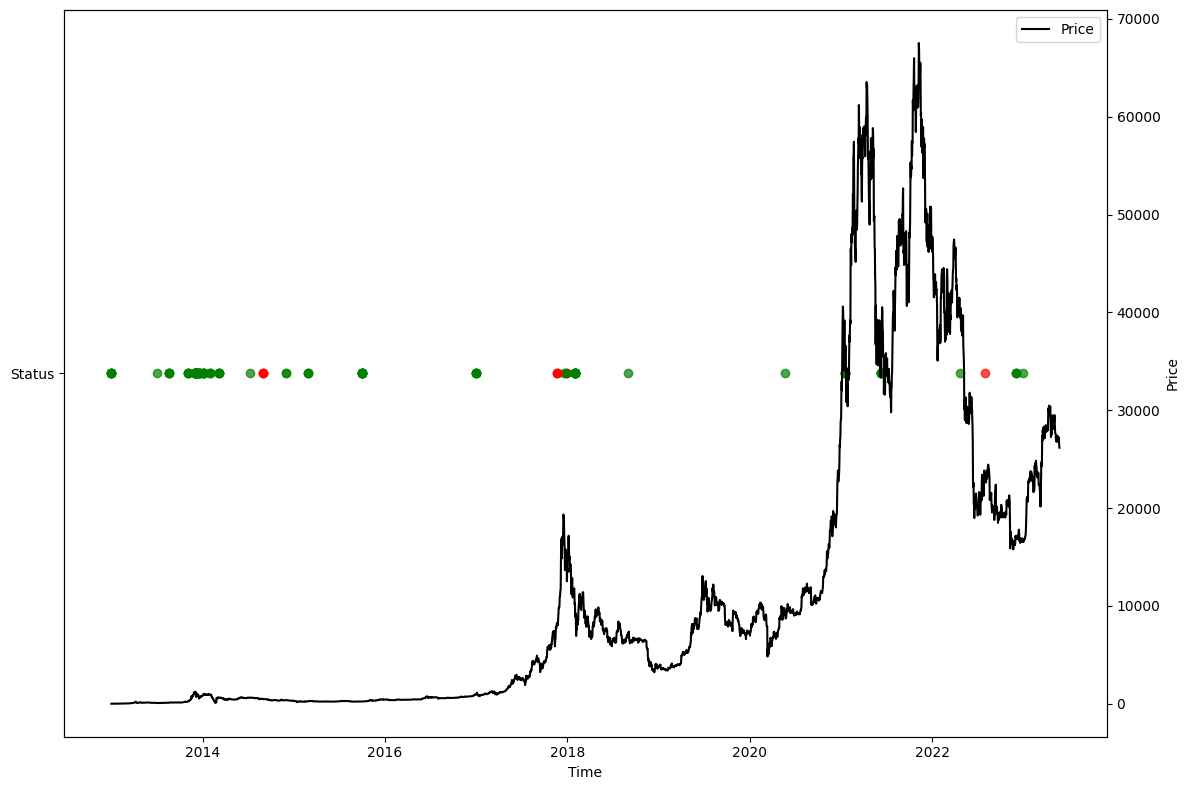

In [16]:
import matplotlib.pyplot as plt

#Read the Excel file
b_price = pd.read_excel('/price.xlsx')
#Convert the "Date" column to datetime format
b_price['Date'] = pd.to_datetime(b_price['Date'])
#Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
#Filter the relevant columns from the merged DataFrame
timeline_data = merged[['Country', 'Date In Text', 'Legal Status']]
#Drop rows with missing or invalid dates
timeline_data = timeline_data.dropna(subset=['Date In Text'])
#Convert the 'Date In Text' column to datetime format
timeline_data['Date In Text'] = pd.to_datetime(timeline_data['Date In Text'], errors='coerce')
#Create a dictionary to map legal statuses to colors
status_colors = {'Legal': 'green', 'Illegal': 'red', 'Others': 'blue'}
#Assign a common y-value to all legal statuses
y_value = 1

#Iterate over each country
for country in timeline_data['Country'].unique():
    #Filter data for the current country
    country_data = timeline_data[timeline_data['Country'] == country]
    #Iterate over each legal status
    for status in status_colors.keys():
        #Filter data for the current legal status
        status_data = country_data[country_data['Legal Status'] == status]
        #Plot a scatter point for each legal status with the corresponding color and adjusted y-value
        ax.scatter(status_data['Date In Text'], [y_value] * len(status_data), color=status_colors[status], label=status, alpha=0.7)

#Set the y-axis ticks and labels
ax.set_yticks([y_value])
ax.set_yticklabels(['Status'])
#Set the x-axis label
ax.set_xlabel('Time')
#Plot the "Price" column against the "Date" column
ax2 = ax.twinx()
ax2.plot(b_price['Date'], b_price['Price'], color='black', linestyle='-', label='Price')
ax2.set_ylabel('Price')
#Add a legend for the new line
ax2.legend(loc='upper right')

#Display the plot
plt.tight_layout()
plt.show()

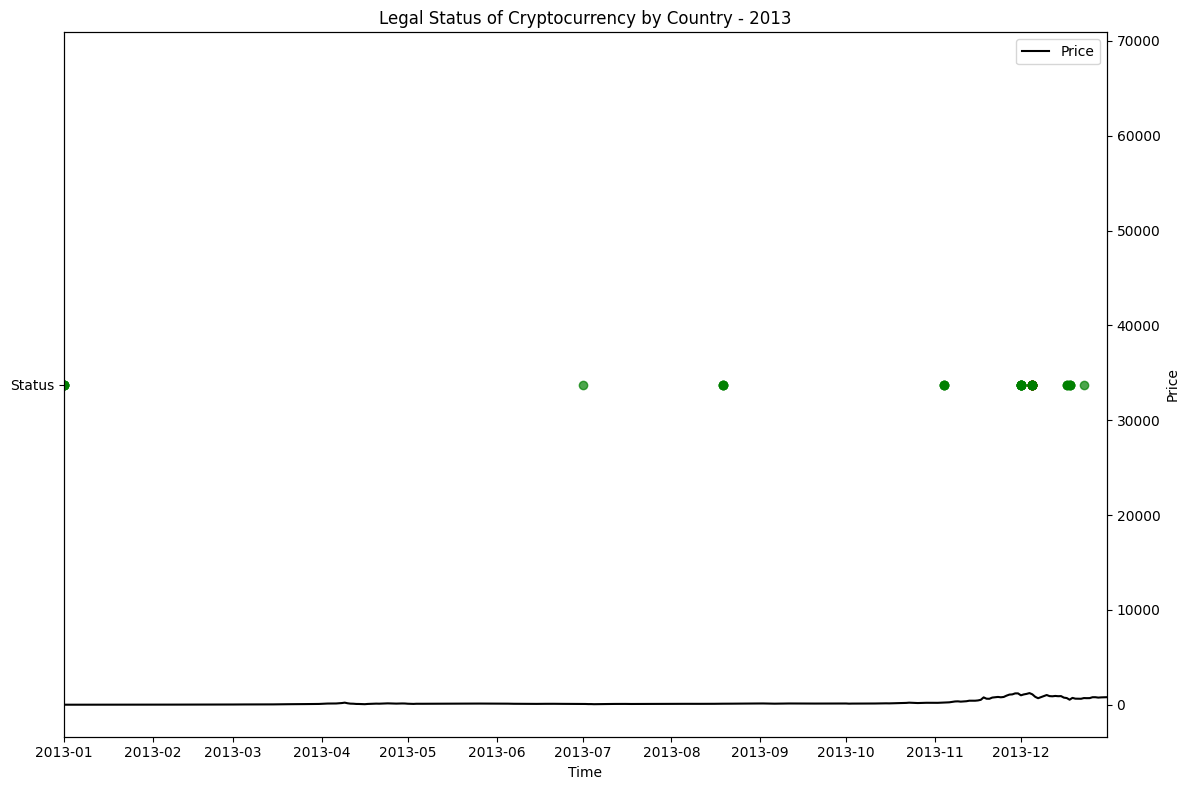

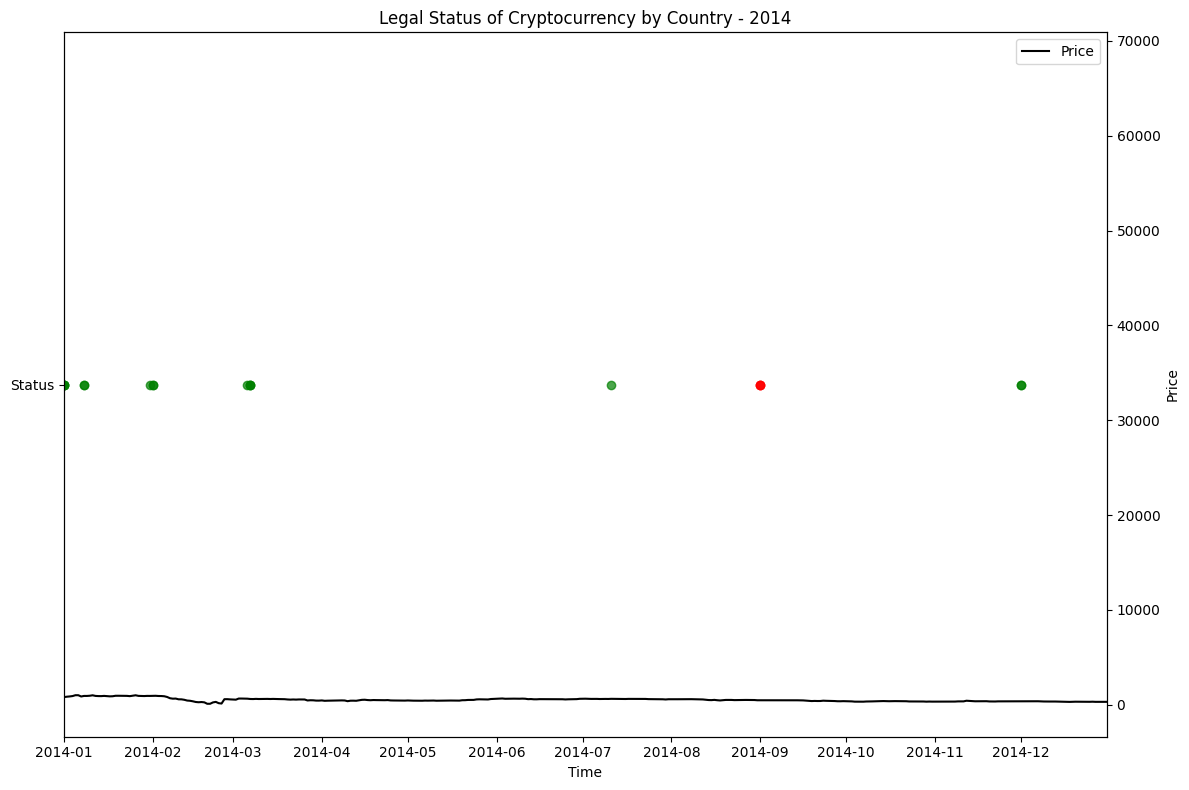

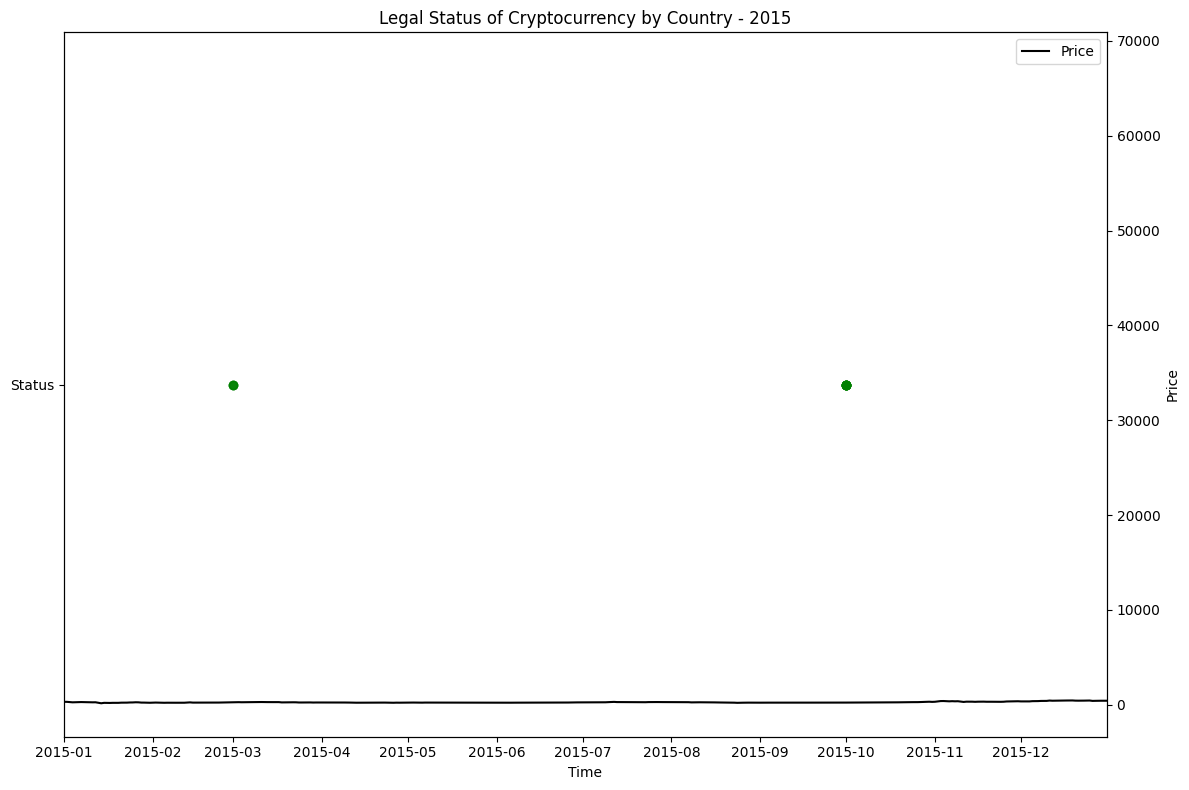

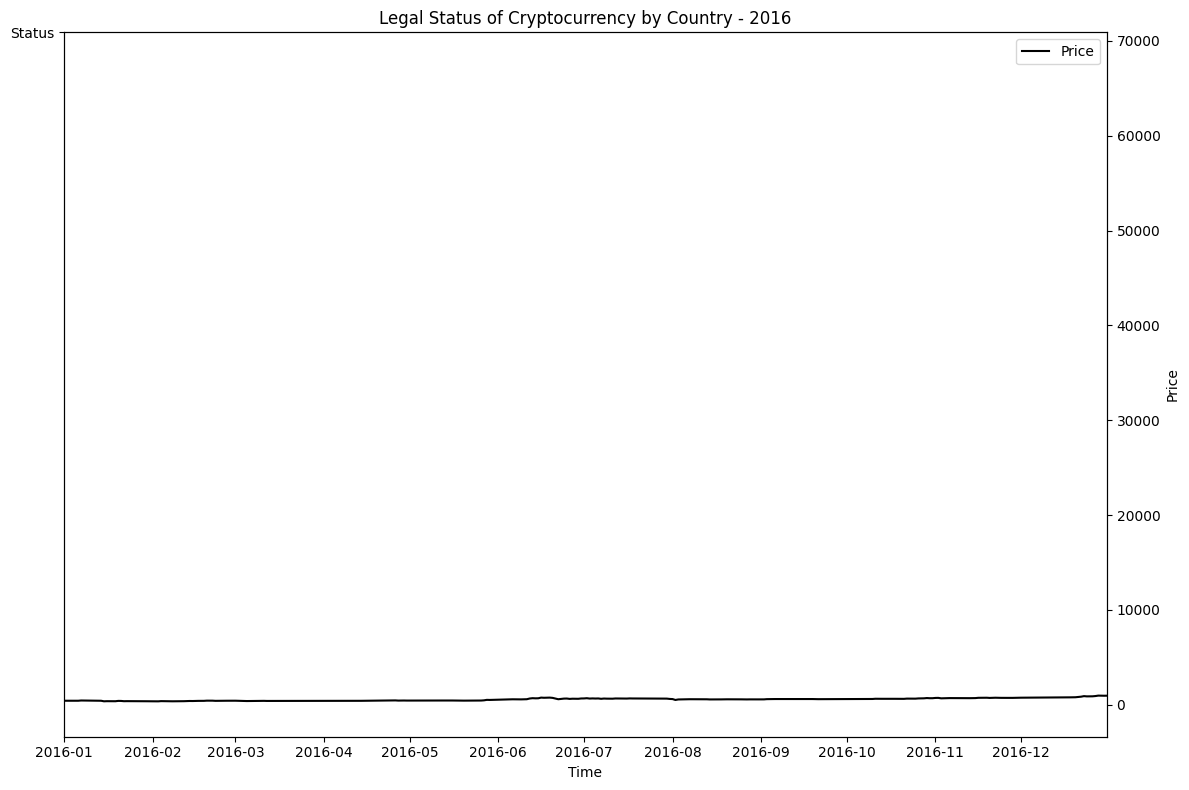

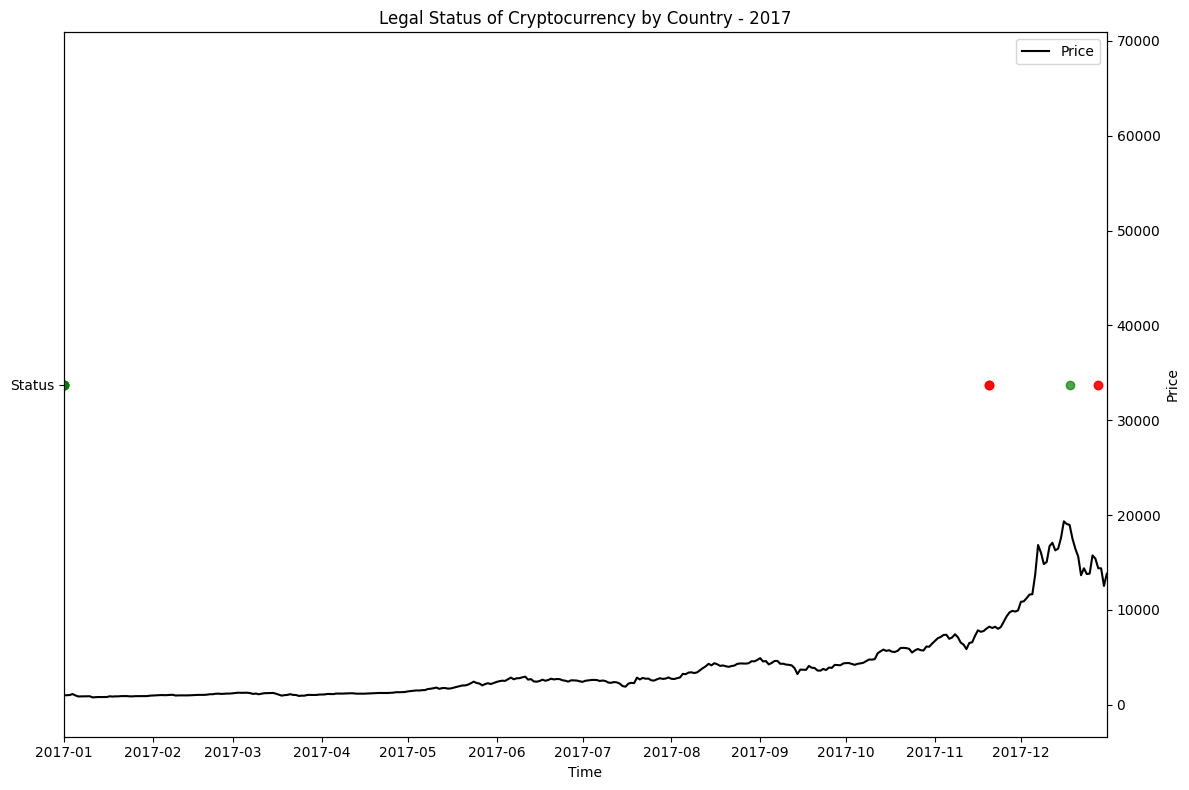

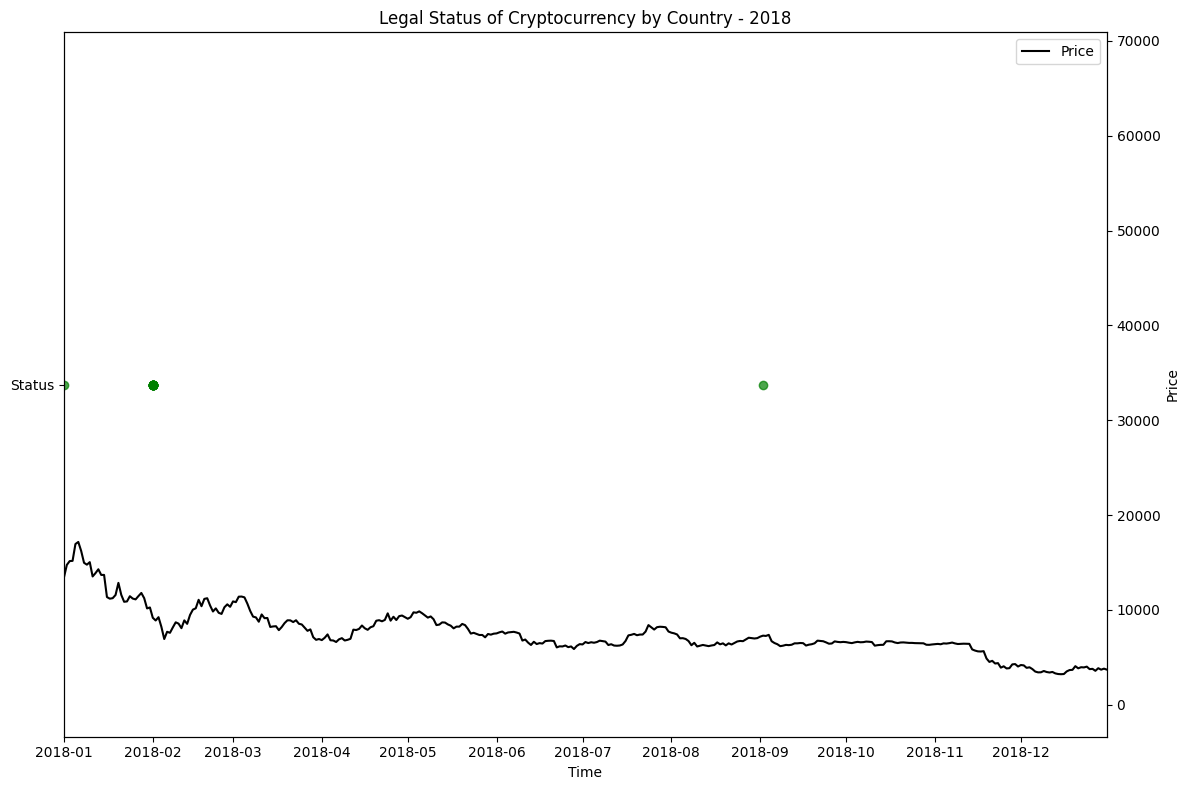

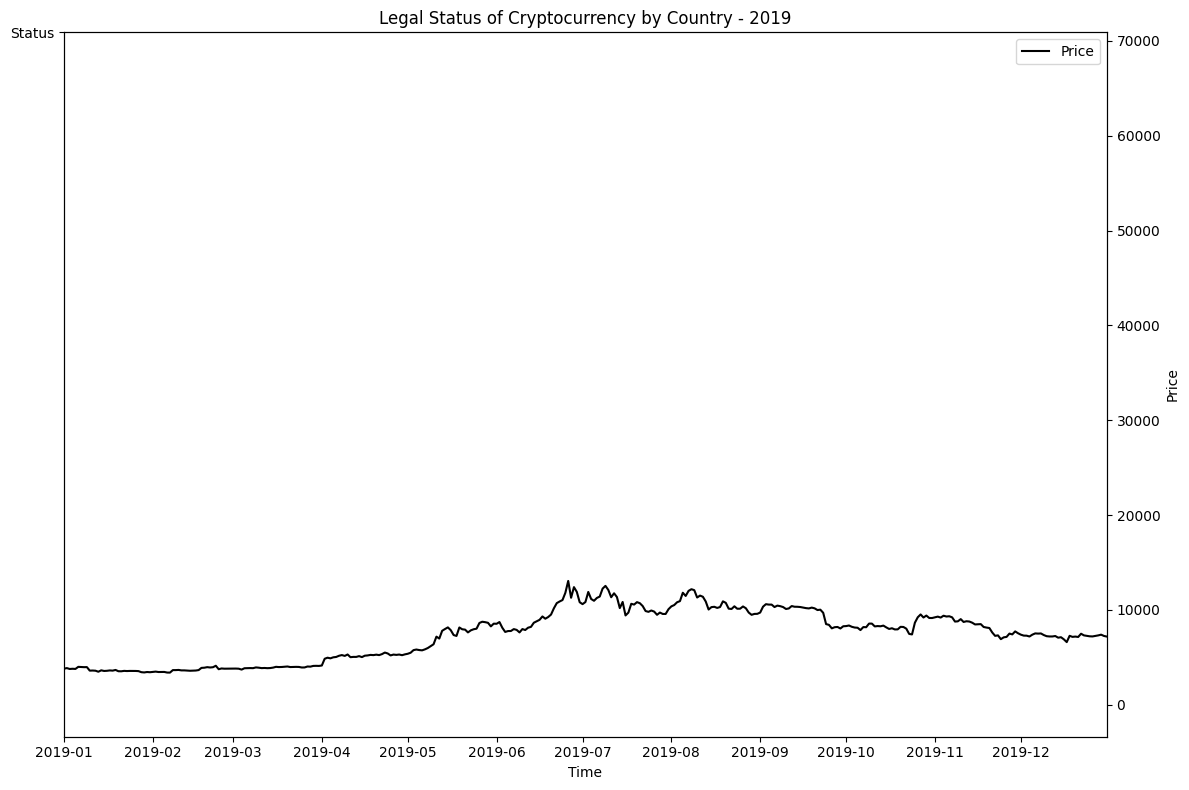

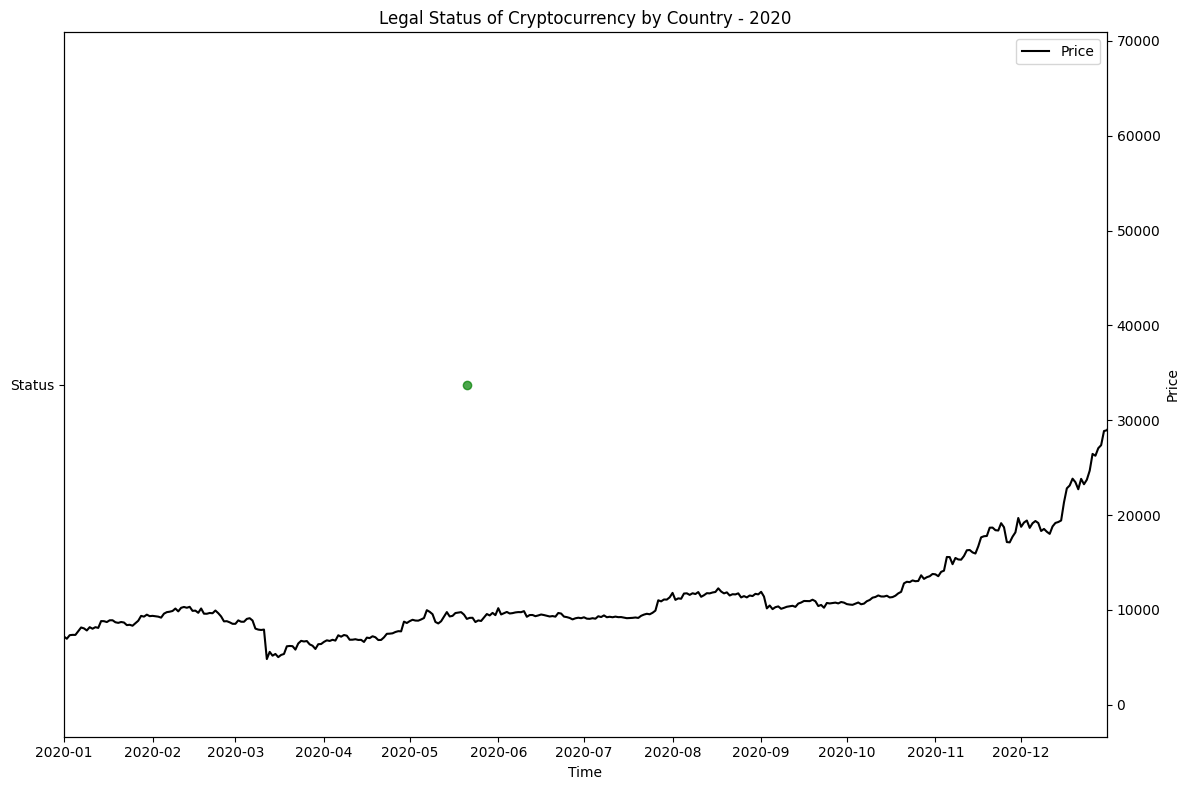

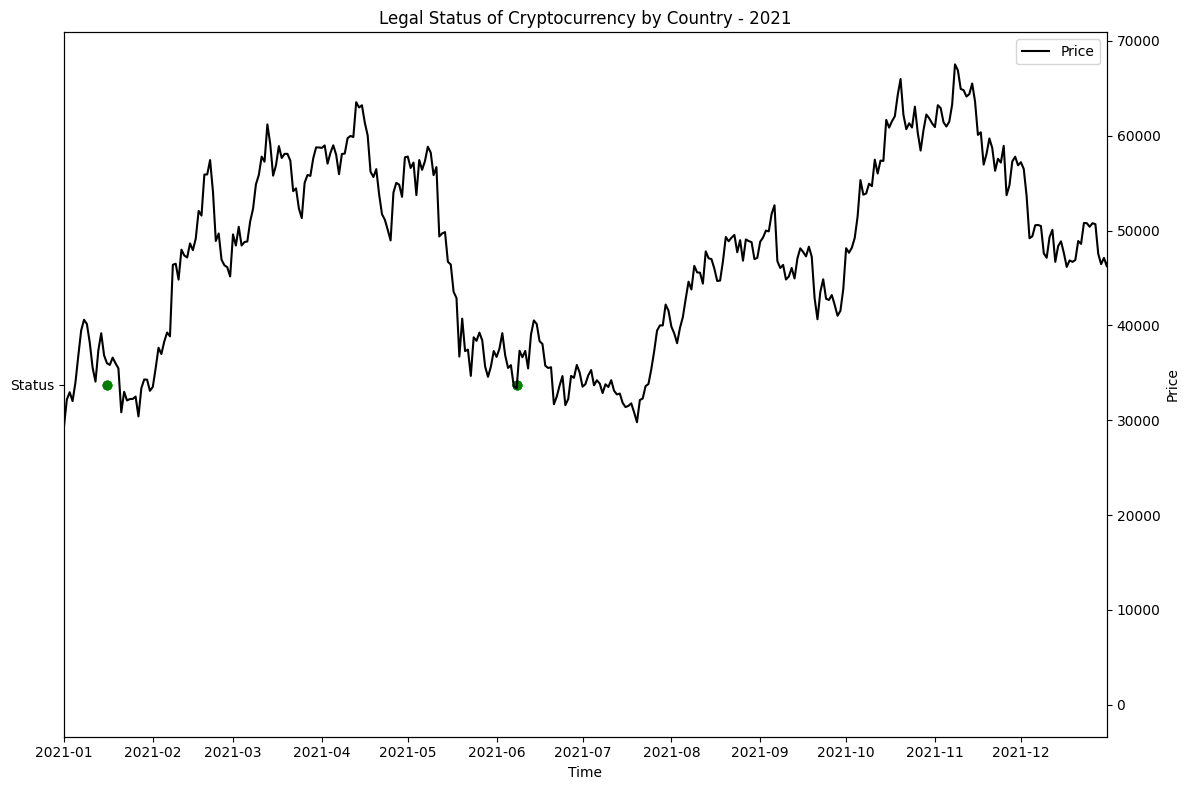

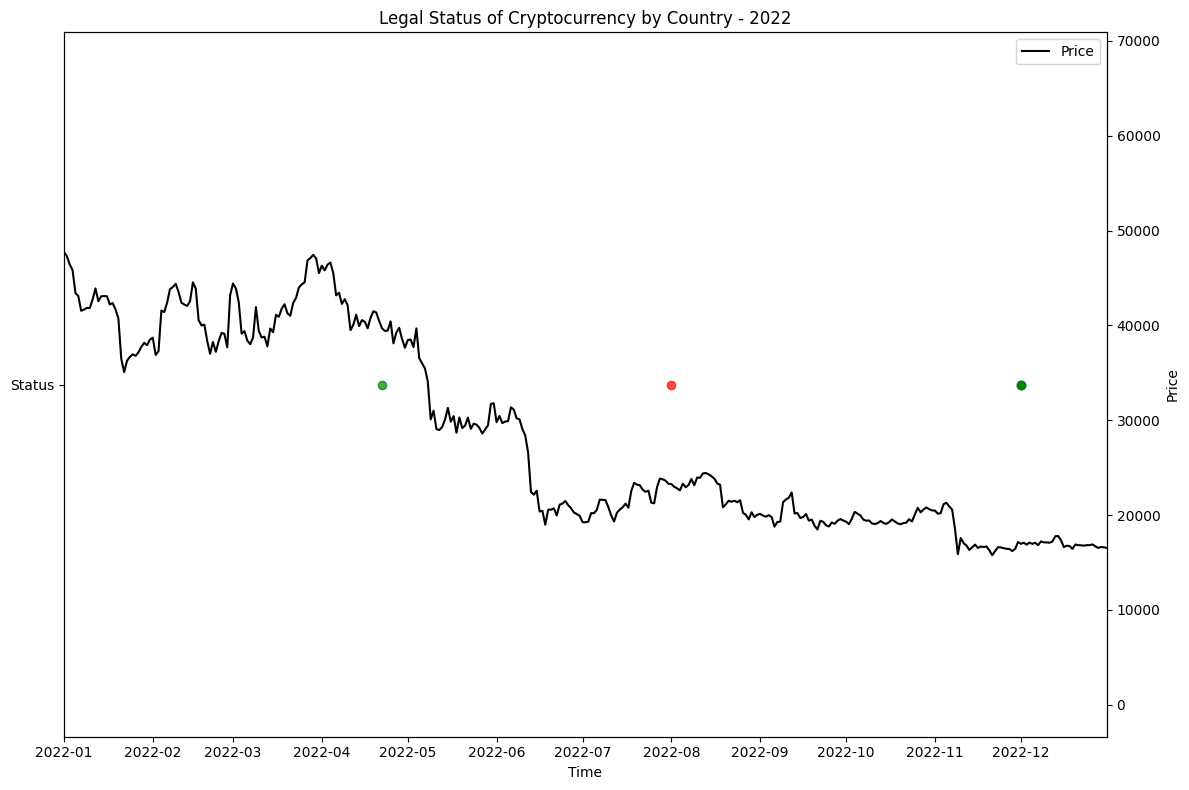

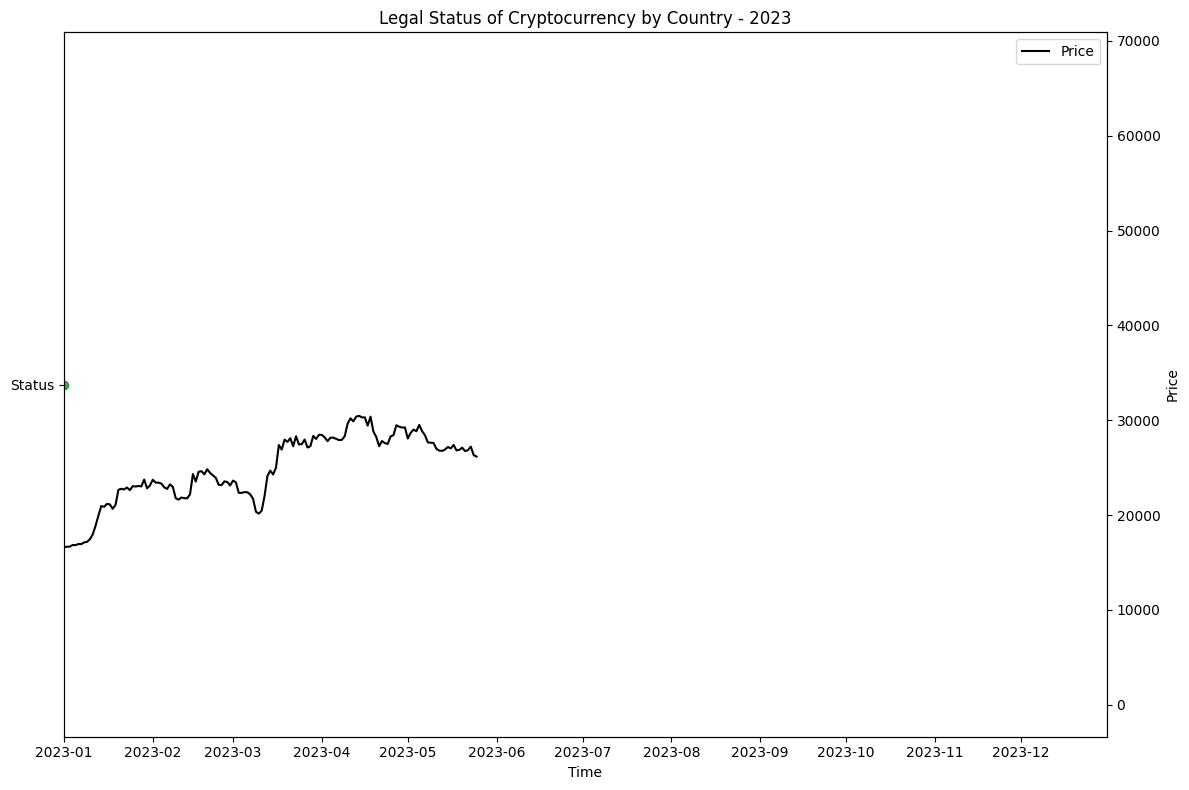

In [17]:
#Convert the "Date" column to datetime format
b_price['Date'] = pd.to_datetime(b_price['Date'])
#Filter the relevant columns from the merged DataFrame
timeline_data = merged[['Country', 'Date In Text', 'Legal Status']]
#Drop rows with missing or invalid dates
timeline_data = timeline_data.dropna(subset=['Date In Text'])
#Convert the 'Date In Text' column to datetime format
timeline_data['Date In Text'] = pd.to_datetime(timeline_data['Date In Text'], errors='coerce')
#Create a dictionary to map legal statuses to colors
status_colors = {'Legal': 'green', 'Illegal': 'red', 'Others': 'blue'}
#Iterate over each year
for year in range(2013, 2024):
    #Filter data for the current year
    year_data = timeline_data[timeline_data['Date In Text'].dt.year == year] 
    #Set up the figure and axis for the current year
    fig, ax = plt.subplots(figsize=(12, 8))
    #Assign a common y-value to all legal statuses
    y_value = 1 
    #Iterate over each country
    for country in year_data['Country'].unique():
        #Filter data for the current country
        country_data = year_data[year_data['Country'] == country]
        #Iterate over each legal status
        for status in status_colors.keys():
            #Filter data for the current legal status
            status_data = country_data[country_data['Legal Status'] == status]
            #Plot a scatter point for each legal status with the corresponding color and adjusted y-value
            ax.scatter(status_data['Date In Text'], [y_value] * len(status_data), color=status_colors[status], label=status, alpha=0.7)
    
    #Set the y-axis ticks and labels
    ax.set_yticks([y_value])
    ax.set_yticklabels(['Status'])
    
    #Set the x-axis limits to January 1 to December 31 of the current year
    ax.set_xlim(pd.Timestamp(year, 1, 1), pd.Timestamp(year, 12, 31))
    
    #Set the x-axis label
    ax.set_xlabel('Time')
    
    #Plot the "Price" column against the "Date" column
    ax2 = ax.twinx()
    ax2.plot(b_price['Date'], b_price['Price'], color='black', linestyle='-', label='Price')
    ax2.set_ylabel('Price')
    
    #Add a legend for the new line
    ax2.legend(loc='upper right')
    
    #Set the title for the current year
    ax.set_title('Legal Status of Cryptocurrency by Country - {}'.format(year))
    
    #Display the plot for the current year
    plt.tight_layout()
    plt.show()

# Topic Modeling

In [18]:
#Import necessary libraries
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('all')
nltk.download('stopwords')
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2022)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]  

In [19]:
#Pre-process text function
def preprocess(text):
    #Tokenize the text
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    #Remove stopwords
    stopword_list = set(stopwords.words("english"))
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in stopword_list]
    #Lemmatize the filtered tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    #Return the lemmatized tokens as a string
    return " ".join(lemmatized_tokens)

In [20]:
###Topic Modeling for wiki page

#Check if any row in "Remaining Text" column contains NaN values
if merged["Remaining Text"].isnull().sum() > 0:
    #Drop rows with NaN values in "Remaining Text" column
    merged.dropna(subset=["Remaining Text"], inplace=True)

#Preprocess the text data in "Remaining Text" column
processed_docs1 = merged["Remaining Text"].apply(preprocess)

#Convert processed_docs to a list of lists:
processed_docs1 = [doc1.split() for doc1 in processed_docs1]

#Build a dictionary representation of the documents
dictionary1 = gensim.corpora.Dictionary(processed_docs1)
#Filter out the extremes (similar to the min/max df step used when creating the TF-IDF matrix)
dictionary1.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
#Bag-of-words representation of the documents
bow_corpus1 = [dictionary1.doc2bow(doc1) for doc1 in processed_docs1]

#Train a LDA model
num_topics = 10
lda_model1 = gensim.models.LdaMulticore(bow_corpus1, num_topics=num_topics, id2word=dictionary1)

#Get the most dominant topic for each row
topic_weights1 = []
for row1 in lda_model1[bow_corpus1]:
    row_weights1 = [w1[1] for w1 in row1]
    topic_weights1.append(row_weights1)

dominant_topic1 = [np.argmax(weights1) for weights1 in topic_weights1]

#Get the topic words for each dominant topic
topic_words1 = []
for topic_id1 in range(num_topics):
    top_words1 = [(word1, prob1) for word1, prob1 in lda_model1.show_topic(topic_id1, topn=10)]
    topic_words1.append(top_words1)

#Reset the indices of the DataFrame
merged.reset_index(inplace=True, drop=True)

#Append the dominant topic and topic words to the DataFrame
merged["Dominant_Topic"] = dominant_topic1
merged["Topic_Words"] = [topic_words1[idx1] for idx1 in dominant_topic1]

#Print the DataFrame with the new columns
display(merged)

,Country,Legal Status,Remaining Text,Date In Text,Reference number,Citation Id,Citation Link,Citation Date,Citation number,Article Contents,Article Contents (EN),Dominant_Topic,Topic_Words
0,Afghanistan,Illegal,In August 2022 Taliban banned trading in cryp...,2022-08-01,57,cite_note-57,https://www.bloomberg.com/news/articles/2022-0...,2022-08-26,57,Why did this happen?\n\nPlease make sure your ...,Why did this happen?\n\nPlease make sure your ...,8,"[(cryptocurrencies, 0.027421128), (financial, ..."
1,Albania,Legal,"On 21 May 2020, Albania passed a new law to r...",2020-05-21,150,cite_note-150,https://www.tagesanzeiger.ch/schweizer-boerse-...,2021-06-11,150,Digitale Währung im Aufwind – Schweizer Börse ...,Digital currency on the upswing - Swiss stock ...,4,"[(cryptocurrency, 0.048053768), (payment, 0.01..."
2,Algeria,Illegal,"According to the ""Journal Officiel"" (28 Decem...",2017-12-28,14,cite_note-RCAWJune2018LOC-14,https://www.loc.gov/item/2021687419/,2018-08-14,14,Publications of the Law Library of Congress ar...,Publications of the Law Library of Congress ar...,0,"[(virtual, 0.0456722), (foreign, 0.033126935),..."
3,Algeria,Illegal,"According to the ""Journal Officiel"" (28 Decem...",2017-12-28,13,cite_note-13,https://www.joradp.dz/FTP/jo-francais/2017/F20...,2019-01-03,13,,Translation Unavailable,0,"[(virtual, 0.0456722), (foreign, 0.033126935),..."
4,Angola,Legal,While government officials have advised again...,NaN,24,cite_note-24,https://www.youtube.com/watch?v=CxporKEMZY4,2020-01-07,24,,Translation Unavailable,2,"[(cryptocurrency, 0.036786333), (market, 0.030..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,Vanuatu,Legal,Legalised in 2021.[193],NaN,193,cite_note-193,https://www.rnz.co.nz/international/pacific-ne...,2021-03-14,193,The tiny Pacific Island nation of Tuvalu is pl...,Translation Unavailable,7,"[(virtual, 0.0326126), (law, 0.022501374), (us..."
238,Venezuela,Legal,Bitcoin miners used to be arrested by law enf...,2018-01-01,56,cite_note-56,https://www.crypto-economy.net/en/venezuelan-g...,2018-07-27,56,The decisions of Venezuela’s socialist governm...,The decisions of Venezuela’s socialist governm...,1,"[(european, 0.02573904), (financial, 0.0212385..."
239,Vietnam,Legal to trade and hold / Illegal as payment ...,The State Bank of Vietnam has declared that t...,NaN,125,cite_note-125,https://thanhnien.vn/content/NzA4Mzgz.html,2017-11-06,125,"Mua vé máy bay, thực phẩm... bằng bitcoin\n\nN...","Buy air tickets, food ... with Bitcoin\n\nOn O...",0,"[(virtual, 0.0456722), (foreign, 0.033126935),..."
240,Vietnam,Legal to trade and hold / Illegal as payment ...,The State Bank of Vietnam has declared that t...,NaN,124,cite_note-124,https://tuoitre.vn/news-20171028102135916.htm,2017-10-28,124,,Translation Unavailable,0,"[(virtual, 0.0456722), (foreign, 0.033126935),..."


In [21]:
###Topic Modeling for article contents after translation

#Check if any row in "Article Contents" column contains NaN values
if merged["Article Contents (EN)"].isnull().sum() > 0:
    #Drop rows with NaN values in "Article Contents" column
    merged.dropna(subset=["Article Contents (EN)"], inplace=True)

#Preprocess the text data in "Article Contents" column
processed_docs2 = merged["Article Contents (EN)"].apply(preprocess)

#Convert processed_docs to a list of lists:
processed_docs2 = [doc2.split() for doc2 in processed_docs2]

#Build a dictionary representation of the documents
dictionary2 = gensim.corpora.Dictionary(processed_docs2)
#Filter out the extremes (similar to the min/max df step used when creating the TF-IDF matrix)
dictionary2.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
#Bag-of-words representation of the documents
bow_corpus2 = [dictionary2.doc2bow(doc2) for doc2 in processed_docs2]

#Train a LDA model
num_topics = 10
lda_model2 = gensim.models.LdaMulticore(bow_corpus2, num_topics=num_topics, id2word=dictionary2)

#Get the most dominant topic for each row
topic_weights2 = []
for row2 in lda_model2[bow_corpus2]:
    row_weights2 = [w2[1] for w2 in row2]
    topic_weights2.append(row_weights2)

dominant_topic2 = [np.argmax(weights2) for weights2 in topic_weights2]

#Get the topic words for each dominant topic
topic_words2 = []
for topic_id2 in range(num_topics):
    top_words2 = [(word2, prob2) for word2, prob2 in lda_model2.show_topic(topic_id2, topn=10)]
    topic_words2.append(top_words2)

#Reset the indices of the DataFrame
merged.reset_index(inplace=True, drop=True)

#Append the dominant topic and topic words to the DataFrame
merged["Dominant_Topic2"] = dominant_topic2
merged["Topic_Words2"] = [topic_words2[idx2] for idx2 in dominant_topic2]

#Print the DataFrame with the new columns
display(merged)

,Country,Legal Status,Remaining Text,Date In Text,Reference number,Citation Id,Citation Link,Citation Date,Citation number,Article Contents,Article Contents (EN),Dominant_Topic,Topic_Words,Dominant_Topic2,Topic_Words2
0,Afghanistan,Illegal,In August 2022 Taliban banned trading in cryp...,2022-08-01,57,cite_note-57,https://www.bloomberg.com/news/articles/2022-0...,2022-08-26,57,Why did this happen?\n\nPlease make sure your ...,Why did this happen?\n\nPlease make sure your ...,8,"[(cryptocurrencies, 0.027421128), (financial, ...",2,"[(bitcoin, 0.039872903), (said, 0.03855583), (..."
1,Albania,Legal,"On 21 May 2020, Albania passed a new law to r...",2020-05-21,150,cite_note-150,https://www.tagesanzeiger.ch/schweizer-boerse-...,2021-06-11,150,Digitale Währung im Aufwind – Schweizer Börse ...,Digital currency on the upswing - Swiss stock ...,4,"[(cryptocurrency, 0.048053768), (payment, 0.01...",1,"[(use, 0.044322327), (virtual, 0.029232277), (..."
2,Algeria,Illegal,"According to the ""Journal Officiel"" (28 Decem...",2017-12-28,14,cite_note-RCAWJune2018LOC-14,https://www.loc.gov/item/2021687419/,2018-08-14,14,Publications of the Law Library of Congress ar...,Publications of the Law Library of Congress ar...,0,"[(virtual, 0.0456722), (foreign, 0.033126935),...",0,"[(use, 0.045060065), (bitcoin, 0.037588846), (..."
3,Algeria,Illegal,"According to the ""Journal Officiel"" (28 Decem...",2017-12-28,13,cite_note-13,https://www.joradp.dz/FTP/jo-francais/2017/F20...,2019-01-03,13,,Translation Unavailable,0,"[(virtual, 0.0456722), (foreign, 0.033126935),...",6,"[(translation, 0.12544474), (unavailable, 0.12..."
4,Angola,Legal,While government officials have advised again...,NaN,24,cite_note-24,https://www.youtube.com/watch?v=CxporKEMZY4,2020-01-07,24,,Translation Unavailable,2,"[(cryptocurrency, 0.036786333), (market, 0.030...",6,"[(translation, 0.12544474), (unavailable, 0.12..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,Vanuatu,Legal,Legalised in 2021.[193],NaN,193,cite_note-193,https://www.rnz.co.nz/international/pacific-ne...,2021-03-14,193,The tiny Pacific Island nation of Tuvalu is pl...,Translation Unavailable,7,"[(virtual, 0.0326126), (law, 0.022501374), (us...",6,"[(translation, 0.12544474), (unavailable, 0.12..."
238,Venezuela,Legal,Bitcoin miners used to be arrested by law enf...,2018-01-01,56,cite_note-56,https://www.crypto-economy.net/en/venezuelan-g...,2018-07-27,56,The decisions of Venezuela’s socialist governm...,The decisions of Venezuela’s socialist governm...,1,"[(european, 0.02573904), (financial, 0.0212385...",2,"[(bitcoin, 0.039872903), (said, 0.03855583), (..."
239,Vietnam,Legal to trade and hold / Illegal as payment ...,The State Bank of Vietnam has declared that t...,NaN,125,cite_note-125,https://thanhnien.vn/content/NzA4Mzgz.html,2017-11-06,125,"Mua vé máy bay, thực phẩm... bằng bitcoin\n\nN...","Buy air tickets, food ... with Bitcoin\n\nOn O...",0,"[(virtual, 0.0456722), (foreign, 0.033126935),...",1,"[(use, 0.044322327), (virtual, 0.029232277), (..."
240,Vietnam,Legal to trade and hold / Illegal as payment ...,The State Bank of Vietnam has declared that t...,NaN,124,cite_note-124,https://tuoitre.vn/news-20171028102135916.htm,2017-10-28,124,,Translation Unavailable,0,"[(virtual, 0.0456722), (foreign, 0.033126935),...",6,"[(translation, 0.12544474), (unavailable, 0.12..."


In [22]:
###Topic Modeling for article contetns without translation

#Check if any row in "Article Contents" column contains NaN values
if merged["Article Contents"].isnull().sum() > 0:
    #Drop rows with NaN values in "Article Contents" column
    merged.dropna(subset=["Article Contents"], inplace=True)

#Preprocess the text data in "Article Contents" column
processed_docs3 = merged["Article Contents"].apply(preprocess)

#Convert processed_docs to a list of lists:
processed_docs3 = [doc3.split() for doc3 in processed_docs3]

#Build a dictionary representation of the documents
dictionary3 = gensim.corpora.Dictionary(processed_docs3)
#Filter out the extremes (similar to the min/max df step used when creating the TF-IDF matrix)
dictionary3.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
#Bag-of-words representation of the documents
bow_corpus3 = [dictionary3.doc2bow(doc3) for doc3 in processed_docs3]

#Train a LDA model
num_topics = 10
lda_model3 = gensim.models.LdaMulticore(bow_corpus3, num_topics=num_topics, id2word=dictionary3)

#Get the most dominant topic for each row
topic_weights3 = []
for row3 in lda_model3[bow_corpus3]:
    row_weights3 = [w3[1] for w3 in row3]
    topic_weights3.append(row_weights3)

dominant_topic3 = [np.argmax(weights3) for weights3 in topic_weights3]

#Get the topic words for each dominant topic
topic_words3 = []
for topic_id3 in range(num_topics):
    top_words3 = [(word3, prob3) for word3, prob3 in lda_model3.show_topic(topic_id3, topn=10)]
    topic_words3.append(top_words3)

#Reset the indices of the DataFrame
merged.reset_index(inplace=True, drop=True)

#Append the dominant topic and topic words to the DataFrame
merged["Dominant_Topic3"] = dominant_topic3
merged["Topic_Words3"] = [topic_words3[idx3] for idx3 in dominant_topic3]

#Print the DataFrame with the new columns
display(merged)

,Country,Legal Status,Remaining Text,Date In Text,Reference number,Citation Id,Citation Link,Citation Date,Citation number,Article Contents,Article Contents (EN),Dominant_Topic,Topic_Words,Dominant_Topic2,Topic_Words2,Dominant_Topic3,Topic_Words3
0,Afghanistan,Illegal,In August 2022 Taliban banned trading in cryp...,2022-08-01,57,cite_note-57,https://www.bloomberg.com/news/articles/2022-0...,2022-08-26,57,Why did this happen?\n\nPlease make sure your ...,Why did this happen?\n\nPlease make sure your ...,8,"[(cryptocurrencies, 0.027421128), (financial, ...",2,"[(bitcoin, 0.039872903), (said, 0.03855583), (...",8,"[(bitcoin, 0.059820388), (currency, 0.04869265..."
1,Albania,Legal,"On 21 May 2020, Albania passed a new law to r...",2020-05-21,150,cite_note-150,https://www.tagesanzeiger.ch/schweizer-boerse-...,2021-06-11,150,Digitale Währung im Aufwind – Schweizer Börse ...,Digital currency on the upswing - Swiss stock ...,4,"[(cryptocurrency, 0.048053768), (payment, 0.01...",1,"[(use, 0.044322327), (virtual, 0.029232277), (...",0,"[(de, 0.22094223), (2017, 0.043035977), (curre..."
2,Algeria,Illegal,"According to the ""Journal Officiel"" (28 Decem...",2017-12-28,14,cite_note-RCAWJune2018LOC-14,https://www.loc.gov/item/2021687419/,2018-08-14,14,Publications of the Law Library of Congress ar...,Publications of the Law Library of Congress ar...,0,"[(virtual, 0.0456722), (foreign, 0.033126935),...",0,"[(use, 0.045060065), (bitcoin, 0.037588846), (...",1,"[(use, 0.04142196), (permission, 0.020172277),..."
3,Algeria,Illegal,"According to the ""Journal Officiel"" (28 Decem...",2017-12-28,13,cite_note-13,https://www.joradp.dz/FTP/jo-francais/2017/F20...,2019-01-03,13,,Translation Unavailable,0,"[(virtual, 0.0456722), (foreign, 0.033126935),...",6,"[(translation, 0.12544474), (unavailable, 0.12...",0,"[(de, 0.22094223), (2017, 0.043035977), (curre..."
4,Angola,Legal,While government officials have advised again...,NaN,24,cite_note-24,https://www.youtube.com/watch?v=CxporKEMZY4,2020-01-07,24,,Translation Unavailable,2,"[(cryptocurrency, 0.036786333), (market, 0.030...",6,"[(translation, 0.12544474), (unavailable, 0.12...",0,"[(de, 0.22094223), (2017, 0.043035977), (curre..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,Vanuatu,Legal,Legalised in 2021.[193],NaN,193,cite_note-193,https://www.rnz.co.nz/international/pacific-ne...,2021-03-14,193,The tiny Pacific Island nation of Tuvalu is pl...,Translation Unavailable,7,"[(virtual, 0.0326126), (law, 0.022501374), (us...",6,"[(translation, 0.12544474), (unavailable, 0.12...",0,"[(de, 0.22094223), (2017, 0.043035977), (curre..."
238,Venezuela,Legal,Bitcoin miners used to be arrested by law enf...,2018-01-01,56,cite_note-56,https://www.crypto-economy.net/en/venezuelan-g...,2018-07-27,56,The decisions of Venezuela’s socialist governm...,The decisions of Venezuela’s socialist governm...,1,"[(european, 0.02573904), (financial, 0.0212385...",2,"[(bitcoin, 0.039872903), (said, 0.03855583), (...",1,"[(use, 0.04142196), (permission, 0.020172277),..."
239,Vietnam,Legal to trade and hold / Illegal as payment ...,The State Bank of Vietnam has declared that t...,NaN,125,cite_note-125,https://thanhnien.vn/content/NzA4Mzgz.html,2017-11-06,125,"Mua vé máy bay, thực phẩm... bằng bitcoin\n\nN...","Buy air tickets, food ... with Bitcoin\n\nOn O...",0,"[(virtual, 0.0456722), (foreign, 0.033126935),...",1,"[(use, 0.044322327), (virtual, 0.029232277), (...",0,"[(de, 0.22094223), (2017, 0.043035977), (curre..."
240,Vietnam,Legal to trade and hold / Illegal as payment ...,The State Bank of Vietnam has declared that t...,NaN,124,cite_note-124,https://tuoitre.vn/news-20171028102135916.htm,2017-10-28,124,,Translation Unavailable,0,"[(virtual, 0.0456722), (foreign, 0.033126935),...",6,"[(translation, 0.12544474), (unavailable, 0.12...",0,"[(de, 0.22094223), (2017, 0.043035977), (curre..."


# Graphs for Topic Modeling Results

In [23]:
merged = merged.dropna(subset=["Remaining Text"])
#Filter the DataFrame to include only the rows where the legal status starts with "Legal"
legal_countries = merged[merged["Legal Status"].str.startswith("Legal")]
legal_countries["Topic_Words"] = [max(topic, key=lambda x: x[1])[0] for topic in legal_countries["Topic_Words"]]
legal_countries["Topic_Words"]

<ipython-input-23-bf51d60b2336>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legal_countries["Topic_Words"] = [max(topic, key=lambda x: x[1])[0] for topic in legal_countries["Topic_Words"]]


1      cryptocurrency
4      cryptocurrency
5             virtual
6             virtual
7      cryptocurrency
            ...      
236           virtual
237           virtual
238          european
239           virtual
240           virtual
Name: Topic_Words, Length: 215, dtype: object

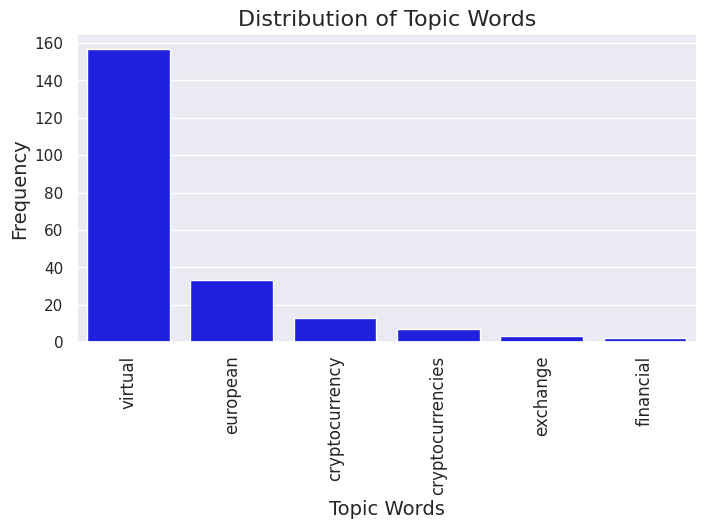

In [24]:
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

###Topic Modeling for wiki: Legal
#Step 1: Create a list of all the words in the legal_df["Topic_Words"] column
all_words = []
for words in legal_countries["Topic_Words"]:
    all_words.append(words)
#Create a Pandas Series with the frequency of each topic word
word_counts = pd.Series(all_words).value_counts()
#Create a bar plot
sns.set(style="darkgrid")
plt.figure(figsize=(8,4))
sns.barplot(x=word_counts.index, y=word_counts.values, color="blue")
plt.title("Distribution of Topic Words", fontsize=16)
plt.xlabel("Topic Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [25]:
#Filter the data to include only countries with legal status starting with "Legal"
merged = merged.dropna(subset=["Remaining Text"])
#Filter the DataFrame to include only the rows where the legal status starts with "Legal"
illegal_countries = merged[merged["Legal Status"].str.startswith("Illegal")]
illegal_countries["Topic_Words"] = [max(topic, key=lambda x: x[1])[0] for topic in illegal_countries["Topic_Words"]]
illegal_countries["Topic_Words"]

<ipython-input-25-0c33f490fbcc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  illegal_countries["Topic_Words"] = [max(topic, key=lambda x: x[1])[0] for topic in illegal_countries["Topic_Words"]]


0      cryptocurrencies
2               virtual
3               virtual
10              virtual
11              virtual
12              virtual
15            financial
16            financial
30             european
31             european
32             european
33             european
34             european
35             european
36             european
37             european
50             exchange
137             virtual
138             virtual
139             virtual
141      cryptocurrency
142      cryptocurrency
Name: Topic_Words, dtype: object

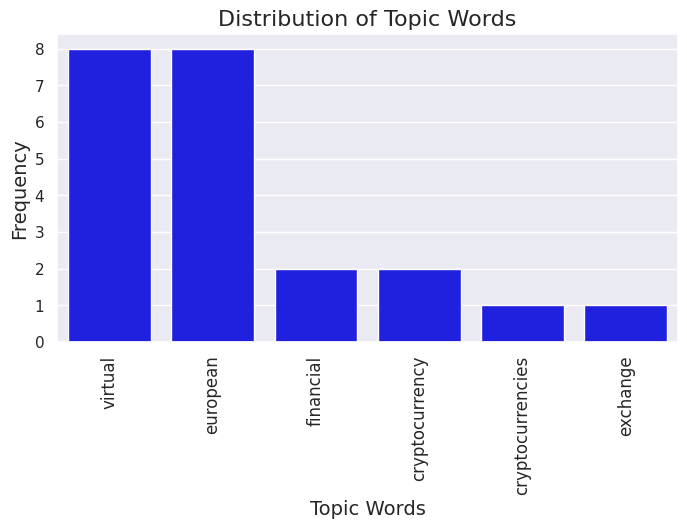

In [26]:
###Topic Modeling for wiki: Illegal
#Step 1: Create a list of all the words in the legal_df["Topic_Words"] column
all_words = []
for words in illegal_countries["Topic_Words"]:
    all_words.append(words)
#Create a Pandas Series with the frequency of each topic word
word_counts = pd.Series(all_words).value_counts()
#Create a bar plot
sns.set(style="darkgrid")
plt.figure(figsize=(8,4))
sns.barplot(x=word_counts.index, y=word_counts.values, color="blue")
plt.title("Distribution of Topic Words", fontsize=16)
plt.xlabel("Topic Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [27]:
#Filter the data to include only countries with legal status starting with "Legal"
merged = merged.dropna(subset=["Remaining Text"])
#Filter the DataFrame to include only the rows where the legal status starts with "Legal"
legal_status_mask = merged[(merged['Legal Status'] != 'Legal') & (merged['Legal Status'] != 'Illegal')]
legal_status_mask["Topic_Words"] = [max(topic, key=lambda x: x[1])[0] for topic in legal_status_mask["Topic_Words"]]
legal_status_mask["Topic_Words"]



<ipython-input-27-08cdcdbb69ef>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legal_status_mask["Topic_Words"] = [max(topic, key=lambda x: x[1])[0] for topic in legal_status_mask["Topic_Words"]]


5      virtual
6      virtual
21     virtual
23     virtual
24     virtual
        ...   
224    virtual
225    virtual
239    virtual
240    virtual
241    virtual
Name: Topic_Words, Length: 62, dtype: object

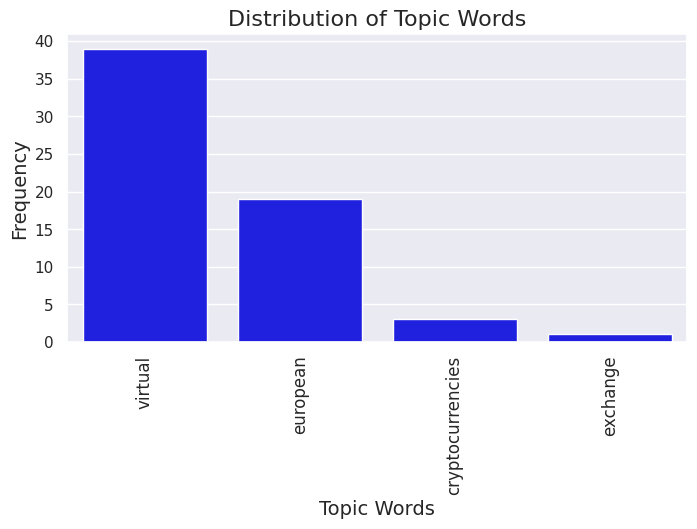

In [28]:
###Topic Modeling for wiki: Others
#Step 1: Create a list of all the words in the legal_df["Topic_Words"] column
all_words = []
for words in legal_status_mask["Topic_Words"]:
    all_words.append(words)
#Create a Pandas Series with the frequency of each topic word
word_counts = pd.Series(all_words).value_counts()
#Create a bar plot
sns.set(style="darkgrid")
plt.figure(figsize=(8,4))
sns.barplot(x=word_counts.index, y=word_counts.values, color="blue")
plt.title("Distribution of Topic Words", fontsize=16)
plt.xlabel("Topic Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [29]:
#Filter the data to include only countries with legal status starting with "Legal"
merged = merged.dropna(subset=["Remaining Text"])
#Filter the DataFrame to include only the rows where the legal status starts with "Legal"
legal_countries1 = merged[merged["Legal Status"].str.startswith("Legal")]
legal_countries1["Topic_Words2"] = [max(topic, key=lambda x: x[1])[0] for topic in legal_countries1["Topic_Words2"]]
legal_countries1["Topic_Words2"]

<ipython-input-29-eba55e55b1f6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legal_countries1["Topic_Words2"] = [max(topic, key=lambda x: x[1])[0] for topic in legal_countries1["Topic_Words2"]]


1              use
4      translation
5              use
6              use
7         currency
          ...     
236    translation
237    translation
238        bitcoin
239            use
240    translation
Name: Topic_Words2, Length: 215, dtype: object

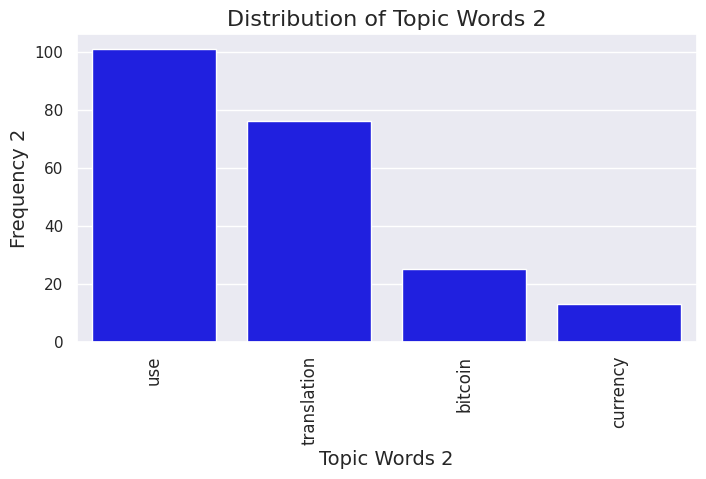

In [30]:
###Topic Modeling for articles: Legal
#Step 1: Create a list of all the words in the legal_df["Topic_Words"] column
all_words1 = []
for words in legal_countries1["Topic_Words2"]:
    all_words1.append(words)
#Create a Pandas Series with the frequency of each topic word
word_counts1 = pd.Series(all_words1).value_counts()
#Create a bar plot
sns.set(style="darkgrid")
plt.figure(figsize=(8,4))
sns.barplot(x=word_counts1.index, y=word_counts1.values, color="blue")
plt.title("Distribution of Topic Words 2", fontsize=16)
plt.xlabel("Topic Words 2", fontsize=14)
plt.ylabel("Frequency 2", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [31]:
#Filter the data to include only countries with legal status starting with "Legal"
merged = merged.dropna(subset=["Remaining Text"])
#Filter the DataFrame to include only the rows where the legal status starts with "Legal"
illegal_countries1 = merged[merged["Legal Status"].str.startswith("Illegal")]
illegal_countries1["Topic_Words2"] = [max(topic, key=lambda x: x[1])[0] for topic in illegal_countries1["Topic_Words2"]]
illegal_countries1["Topic_Words2"]

<ipython-input-31-3665b9ea5256>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  illegal_countries1["Topic_Words2"] = [max(topic, key=lambda x: x[1])[0] for topic in illegal_countries1["Topic_Words2"]]


0          bitcoin
2              use
3      translation
10             use
11             use
12             use
15             use
16             use
30             use
31             use
32         bitcoin
33     translation
34     translation
35             use
36             use
37             use
50             use
137    translation
138            use
139    translation
141       currency
142            use
Name: Topic_Words2, dtype: object

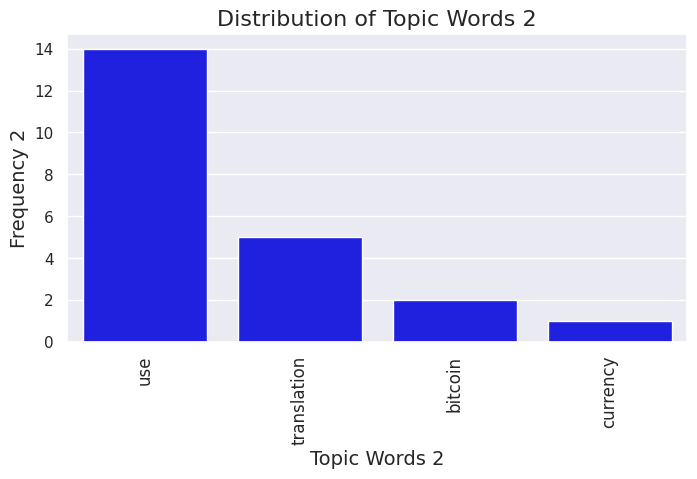

In [32]:
###Topic Modeling for articles: Illegal
#Step 1: Create a list of all the words in the legal_df["Topic_Words"] column
all_words2 = []
for words in illegal_countries1["Topic_Words2"]:
    all_words2.append(words)
#Create a Pandas Series with the frequency of each topic word
word_counts2 = pd.Series(all_words2).value_counts()
#Create a bar plot
sns.set(style="darkgrid")
plt.figure(figsize=(8,4))
sns.barplot(x=word_counts2.index, y=word_counts2.values, color="blue")
plt.title("Distribution of Topic Words 2", fontsize=16)
plt.xlabel("Topic Words 2", fontsize=14)
plt.ylabel("Frequency 2", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [33]:
#Filter the data to include only countries with legal status starting with "Legal"
merged = merged.dropna(subset=["Remaining Text"])
#Filter the DataFrame to include only the rows where the legal status starts with "Legal"
other = merged[(merged['Legal Status'] != 'Legal') & (merged['Legal Status'] != 'Illegal')]
other["Topic_Words2"] = [max(topic, key=lambda x: x[1])[0] for topic in other["Topic_Words2"]]
other["Topic_Words2"]

<ipython-input-33-71d47daeb417>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other["Topic_Words2"] = [max(topic, key=lambda x: x[1])[0] for topic in other["Topic_Words2"]]


5              use
6              use
21     translation
23             use
24             use
          ...     
224            use
225       currency
239            use
240    translation
241    translation
Name: Topic_Words2, Length: 62, dtype: object

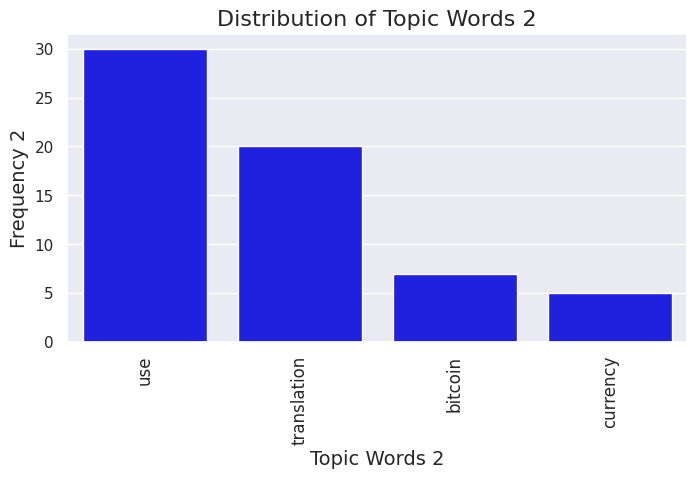

In [34]:
###Topic Modeling for articles: Others
#Step 1: Create a list of all the words in the legal_df["Topic_Words"] column
all_words3 = []
for words in other["Topic_Words2"]:
    all_words3.append(words)
#Create a Pandas Series with the frequency of each topic word
word_counts3 = pd.Series(all_words3).value_counts()
#Create a bar plot
sns.set(style="darkgrid")
plt.figure(figsize=(8,4))
sns.barplot(x=word_counts3.index, y=word_counts3.values, color="blue")
plt.title("Distribution of Topic Words 2", fontsize=16)
plt.xlabel("Topic Words 2", fontsize=14)
plt.ylabel("Frequency 2", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.show()